<a href="https://colab.research.google.com/github/ML4SCI/ML4SCIHackathon/blob/main/GoogleEarthEngineChallenge/SupervisedClassificationGEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervised Land-Use/Land-Cover Classification using Google Earth Engine**

This exercise was designed for the Machine Learning for Science (ML4SCI) Hackathon: https://github.com/ML4SCI/ML4SCIHackathon 

**Objectives:** Learn to create and troubleshoot supervised land-use/land-cover (LULC) classifications using Google Earth Engine (GEE). You will use multispectral optical imagery from the Landsat 8 satellite to train a supervised classification model and compare it to the USGS National Land Cover Database. Classification accuracy will be calculated using the results of a confusion matrix and a validation layer. The example below is for testing purposes only and is meant to inspire creative problem solving for improving the overall accuracy of LULC models. You will need a GEE account to participate!

---

### **Why Google Earth Engine?**

Google Earth Engine offers open access to a large suite of geoprocessing tools and an extensive geospatial data catalog. If you haven’t already, sign up for an account using a Gmail address at https://earthengine.google.com/. I recommend perusing this website to become familiar with some of GEE’s capabilities and see how scientists are leveraging the platform https://earthengine.google.com/case_studies/.

Once you've signed up, head over to https://code.earthengine.google.com/ to interact with the code editor. 
The full API can be accessed at https://developers.google.com/earth-engine/api_docs and there is a great intro to coding with GEE at https://developers.google.com/earth-engine/tutorials/community/beginners-cookbook.

*Please note that the Google Earth Engine code editor uses JavaScript. You will need to copy/paste all of the code blocks in this challenge to the Google Earth Engine code editor interface!*



---



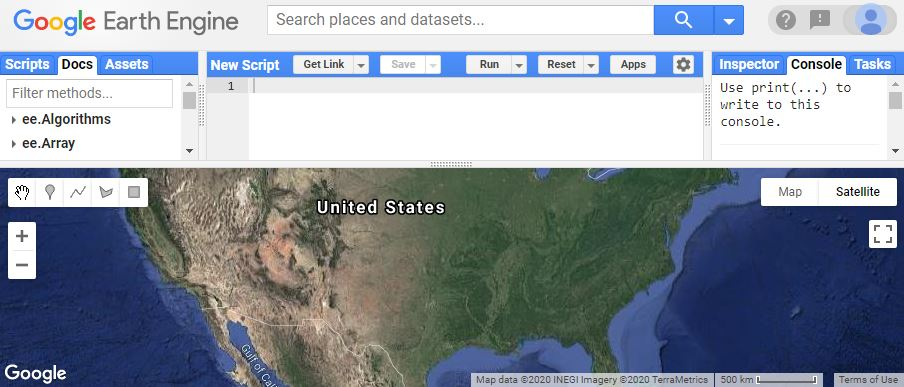

### **Why classify?**
LULC data are needed for many applications, such as wildlife conservation, natural resource management, urban planning, and monitoring agriculture. One of the benefits of remote sensing data for this purpose is that satellite images offer spatially continuous data at regular revisit rates. To track urbanization, for example, we need timeseries LULC classification data to observe where new structures have emerged. To measure agricultural productivity, we first need to identify where agricultural lands are in order to minimize influence of other land cover types (e.g., trees and grasslands) in measurements and summarizations. The USGS NLCD data product is released every 5 years and covers the conterminous U.S., but with rapid global change occurring, supervised classification methods can be used to estimate LULC at frequent time intervals or at specific points in time.

### **What is supervised classification?**
Supervised classification is a technique in which samples with known values (in this case LULC) are used to train a classification algorithm. Here, we'll be accessing the spectral signatures of points across the USGS NLCD dataset and use the reflectance data to train a model that predicts spatially continuous LULC. A random forest decision tree algorithm is supplied by default, but you will be able to test other methods.

For more documentation on supervised classifications visit https://developers.google.com/earth-engine/guides/classification. Not covered here, but also of relevance is unsupervised classifications (e.g., K-means clustering). For details on this topic visit https://developers.google.com/earth-engine/guides/clustering.

### **How does surface reflectance work?**
Multispectral optical imagery contains a wealth of information that can be used to distinguish features on the earth's surface. Solar radiation travels to the earth and wavelengths of light are absorbed and reflected differently by different materials/objects. The reflected solar radiation is what is captured by the satellite. These data can then be used to classify land-use/land-cover based on the spectral signatures of the objects.

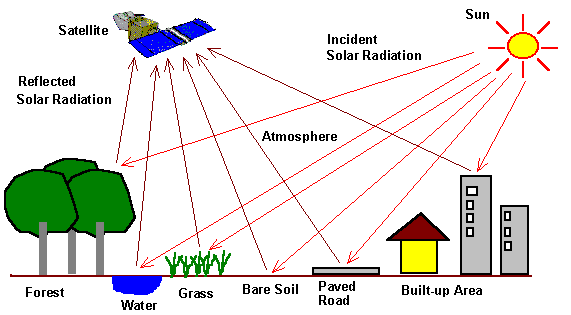

Diagram source: https://crisp.nus.edu.sg/



---



**Task 1** - Adding geometries to set boundaries for image data extraction. 

Add this block to your code editor. The point geometry will be used to isolate image tiles around the Austin, Texas area and the rectangular boundary geometry will be used to clip the extent. The last line will center your map to this region and change the basemap view to satellite.

**Please note that if you try to run the code within this notebook you will receive an error! Copy/paste all of the code blocks in this challenge to the Google Earth Engine code editor interface.**

Click **Run** in the Google Earth Engine code editor to center the map on the polygon geometry defined below.

In [ ]:
var point = ee.Geometry.Point([-97.75652736866604, 30.287326928802763])
var bounds = ee.Geometry.Polygon(
  [[[-97.90557204499963, 30.366990823768905],
    [-97.90557204499963, 30.238939859500963],
    [-97.33634291902307, 30.238939859500963],
    [-97.33634291902307, 30.366990823768905]]], null, false)
Map.centerObject(bounds).setOptions('HYBRID')



---



**Task 2** - Loading the USGS National Land Cover Database (NLCD)—https://developers.google.com/earth-engine/datasets/catalog/USGS_NLCD and retrieving map projection information.

Use this code block to load NLCD for the year 2016 and remap the LULC categories to new values ranging from 0–19. In GEE, it's important to select the band you'd like to pull from the data product. If you follow the link above and navigate to 'Bands' tab, you will see that the data product contains many options. As you see in the code below, we have selected to isolate the 'landcover' band. The purpose of this remapping is to make visualizations consistent across products later in the script.

After this step, we're going to add the Landsat 8 imagery, perform a cloud filtering operation, then you we'll add the data to the map.

Click **Run** to execute the code and see the NLCD layer metadata printed to **Console** (tab in the top right of UI).

In [ ]:
var nlcd2016 = ee.Image("USGS/NLCD/NLCD2016")
  .select('landcover').clip(bounds)
  .aside(print)
  
var nlcdRemap = nlcd2016
  .remap([11,12,21,22,23,24,31,41,42,43,51,52,71,72,73,74,81,82,90,95],
         [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])
  .rename('landcover')

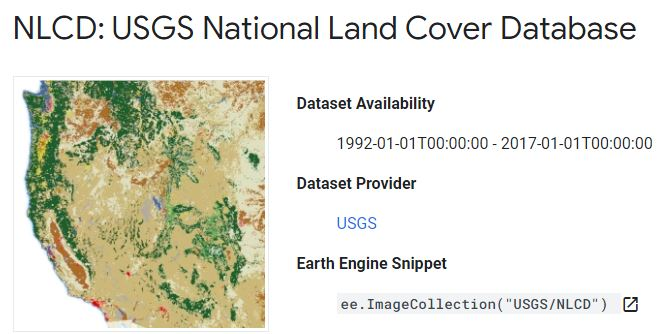



---



**Task 3** - Loading USGS Landsat 8 Surface Reflectance Tier 1 imagery—https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR.

In this section, we'll first sort the Landsat 8 image collection by the 'CLOUD_COVER' property to retrieve the least cloudy image for 2016. Why 2016? We're going to focus on the year 2016 here because it matches the date of the USGS NLCD data. Afterward, we'll use the bitmask QA band to remove any remaining cloud cover.

Click **Run** to execute the code and see the Landsat 8 layer metadata printed to Console.

In [ ]:
var collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
  .filterBounds(point).filterDate('2016-01-01', '2016-12-31')
  .aside(print)

var image = collection.sort('CLOUD_COVER')
  .first().clip(bounds)

var qa = image.select('pixel_qa')
var cloudMask = qa.bitwiseAnd(1<<5).eq(0)
  .and(qa.bitwiseAnd(1<<3).eq(0))
var masked = image.updateMask(cloudMask).clip(bounds)

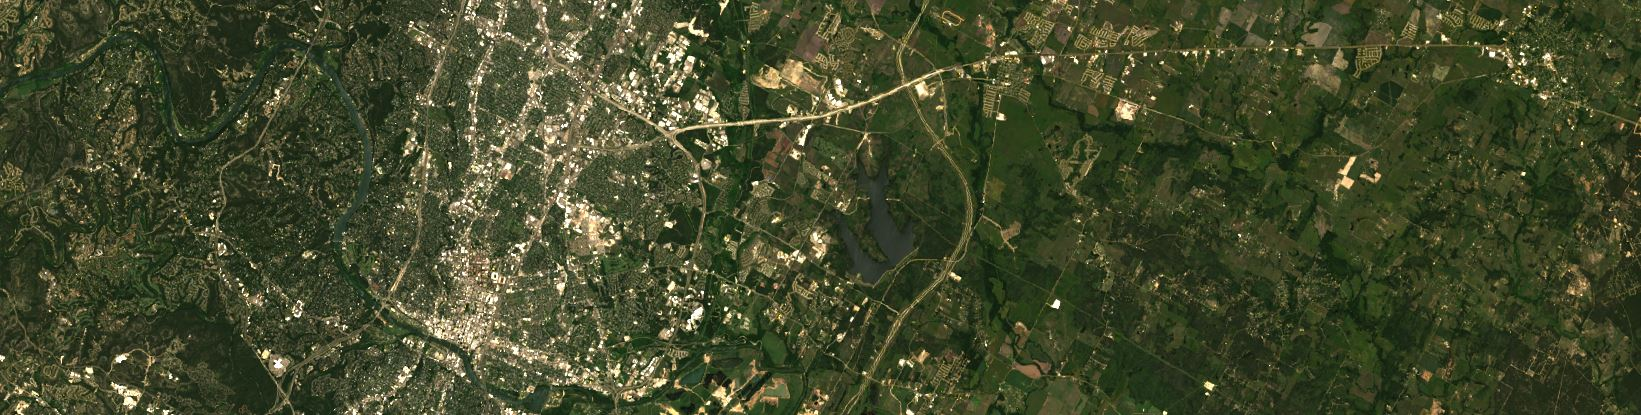



---



**Task 4** - Add NLCD 2016 data and the Landsat 8 image to the display and center the map to the boundary polygon.

Click **Run** in the Google Earth Engine code editor to see the Landsat 8 imagery and the USGS NLCD layer added to the map with the visualization parameters added below. Look for the Layers panel in the top right of the map to turn layers on/off.

**Pan, zoom, and use the Inspector tool (top right of UI) to explore the data!**

In [ ]:
var classColors = [
  '476ba1','d1defa','decaca','d99482','ee0000',
  'ab0000','b3aea3','68ab63','1c6330','b5ca8f',
  'a68c30','ccba7d','e3e3c2','caca78','99c247',
  '78ae94','dcd93d','ab7028','bad9eb','70a3ba'
]

Map.addLayer(image,{min:0,max:2500,bands:['B4','B3','B2']},'true color image',true)
Map.addLayer(nlcdRemap,{min:0,max:19,palette:classColors},'nlcd 2016',true)

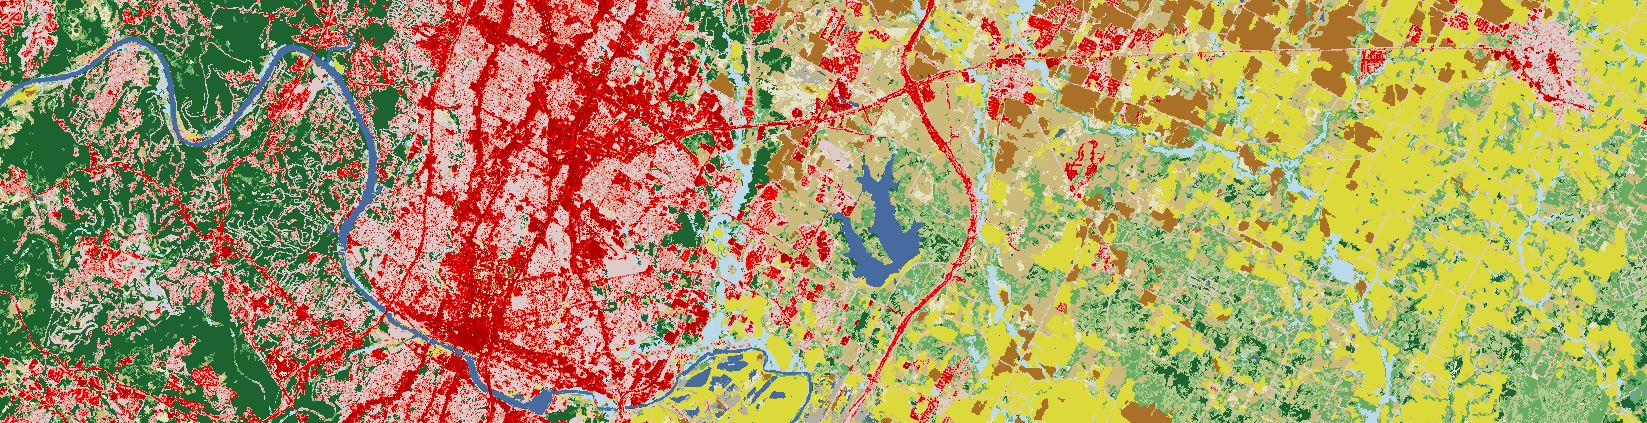



---



# **Supervised Classification Parameterization**

**Task 5** - Setting and modifying the classification model parameters.

This section is where many adjustments can be made to improve model accuracy. Note that by default only bands 'B2', 'B3', and 'B4' have been included here, which corresponde with blue, green, and red spectral reflectances, respectively. If you check the Landsat 8 SR metadata (linked above), you will see there are other bands available for use, namely near infrared ('B5'), shortwave infrared ('B6' and 'B7'), and brightness temperature ('B10' and 'B11'). 

Check the GEE documentation for other classification systems, e.g., classification and regression tree (CART) and support vector machine (SVM). The default parameters and classification set here are not optimized and the challenge is for you to test alternative methods and parameters.

Use the **Docs** tab (top left of UI) to see other available classification systems, as well as the other arguments that ee.Classifier.smileRandomForest accepts.

In [ ]:
var bands = ['B2','B3','B4']
var classifier = ee.Classifier.smileRandomForest({numberOfTrees:10})
var sampleSize = 500



---



**Task 6** - Executing the classification using a training sample. Note below that the sample size, classifier, and bands selected above are being used here to produce the classification. 

Add this block to your code editor, then click **Run** to see your classified image added to the map! You will also see the training points added as a layer.

In [ ]:
var training = masked.addBands(nlcdRemap).sample({
  numPixels: sampleSize,
  seed: 0,
  geometries: true
})
Map.addLayer(training,{},'training points',true)

var classifier = classifier.train({
  features: training,
  classProperty: 'landcover',
  inputProperties: bands
})

var classified = masked.classify(classifier)
Map.addLayer(classified,{min:0,max:19,palette:classColors},'classification',true)



---



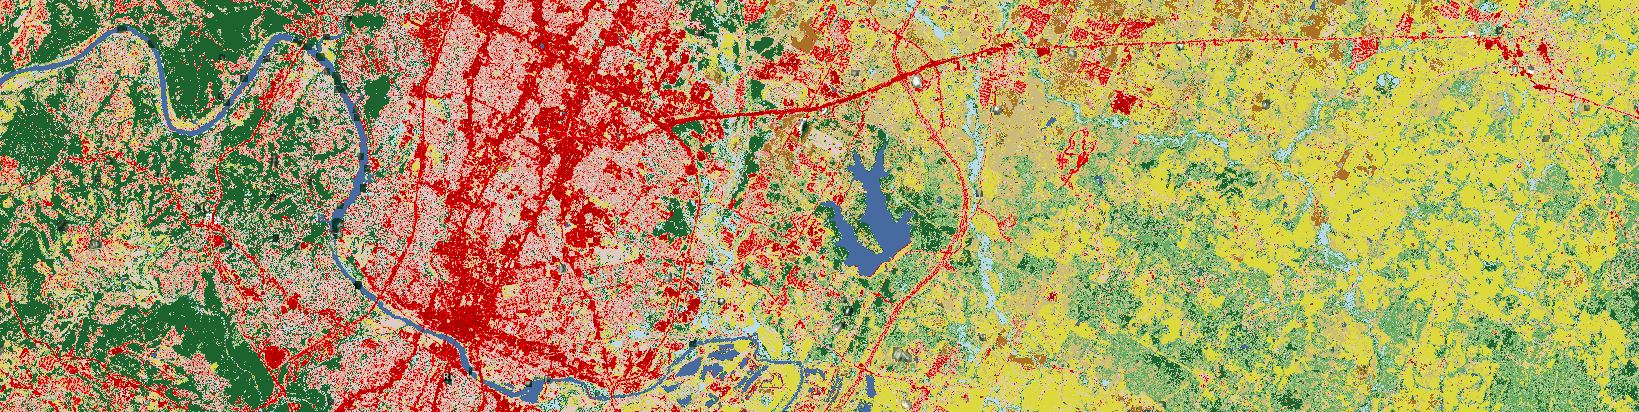

**Task 7** - Evaluating the model accuracy using a confusion matrix. The last line prints the overall accuracy of the training data to the console.

**What is a confusion matrix?**

A confusion matrix is used here to compare two different image grids. We will be using it primarily to compute overall accuracy between the model and the validation layer, but confusion matrices also provide explicit information about which LULC classes were classified incorrectly; not just if pixels were classified incorrectly, but what LULC they were incorrectly classified as. For an example of how to use and interpret a confusion matrix for LULC remote sensing visit https://www.harrisgeospatial.com/docs/CalculatingConfusionMatrices.html.

In [ ]:
print('// Base classification -----')
var trainAccuracy = classifier.confusionMatrix()
print('Resubstitution error matrix: ', trainAccuracy)
print('Training overall accuracy: ', trainAccuracy.accuracy())



---



**Task 8** - To test how effective the model is at predicting LULC, we need to evaluate the model accuracy against a validation sample. The metrics are printed to the console.

Click **Run** to see the accuracy metrics printed to **Console**. 

In [ ]:
var validation = masked.addBands(nlcdRemap).sample({
  numPixels: sampleSize,
  seed: 1
}).filter(ee.Filter.neq('B1', null))

var validated = validation.classify(classifier)
var testAccuracy = validated.errorMatrix('landcover', 'classification')

print('Validation error matrix: ', testAccuracy)
print('Validation overall accuracy: ', testAccuracy.accuracy())



---



**Optional model improvement** - Focal statistics are one way to identify and fill local spatial data outliers in the source image for classification. The modified z-score (Iglewicz and Hoaglin 1993) is presented here as one image filtering algorithm, but you are encouraged to test alternative methods. In fact, this method might only show marginal model improvement in some test cases. Your challenge is to explore other ways of manipulating the starting dataset to improve model accuracy.

Iglewicz, B. and Hoaglin, D.C., 1993. *How to detect and handle outliers*. ASQC Press.

In [ ]:
var kernelSize = 7
var outlierThreshold = 3.5

var kernel = ee.Kernel.square({
  radius:kernelSize,
  units:'pixels'
})

var prj = nlcd2016.projection()
var maskPrj = masked.reproject(prj)
var focalStat = maskPrj.focal_median({kernel:kernel})
var diff = maskPrj.subtract(focalStat)
var mzscore = diff.multiply(0.6745).divide(diff.abs().focal_median({kernel:kernel}).reproject(prj))
var con = mzscore.gt(outlierThreshold) // Outlier threshold selection
var filtered = masked.where(con.eq(1),focalStat)



---



**Optional model comparison** - This is not part of the accuracy assessment, but if you'd like to compare where the two maps agree or disagree, simply subtract one from the other. The code below produces a Boolean grid where 0 = no difference and 1 = difference.

In [ ]:
var difference = classified.subtract(nlcdRemap).neq(0)
Map.addLayer(difference,{min:0,max:1,palette:['gold','crimson']},'difference',false)

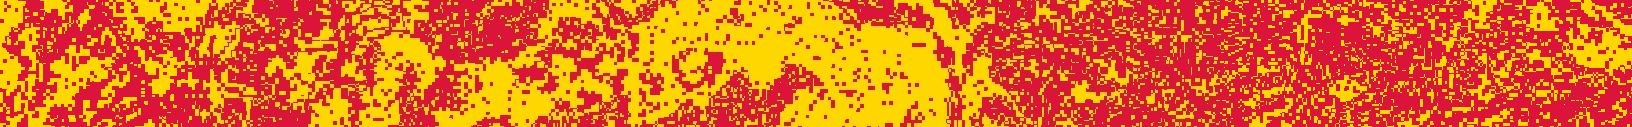

## **Submitting your results**

Submit a lastnameFirstname_GEE_results.txt document that contains each of the required elements below. Evaluation will be based primarily on the overall accuracy achieved using the validation sample, but consideration will also be given to the explanation of parameterization. 

**DUE 10-30-2020 by 6:00pm CST**

Email solutions to ML4SCI2020@gmail.com 

1. Link to GEE script (use the 'Get Link' button at the top of your code editor)
2. Bands selected for parameterization
3. Classification method and parameters selected
4. Sample size selected
5. Rationale for each of the parameters set or post hoc explanation
6. Highest overall training/validation accuracy
7. If you used a method other than what was supplied here, please detail your methods, parameters, and results, otherwise put N/A here.


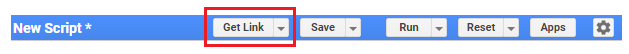



---



## **Contributors**
This exercise was prepared by Dr. Brad G. Peter in the Department of Geography at the University of Alabama. https://cartoscience.com